# Training an autoencoder neural network with stochastic quantization model

Importing all required third-party dependencies

In [1]:
import os
import itertools
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib as mpl
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

from sklearn.metrics import ConfusionMatrixDisplay, f1_score

import sq.optim as sq_optim
import sq.quantization as sq

Choosing a different algorithm for convolutions computations

In [2]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

To enforce reproducibility we set the random seed manually

In [3]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"Used random seed: {torch.initial_seed()}")

Used random seed: 42


We set up the computation device for performing optimization

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"

We will use MNIST dataset of handwritten digits

In [5]:
EPOCHS = 50

BATCH_TRAIN = 1024
BATCH_TEST = 1024
DATA_DIR = '../../data/'
RESULTS_DIR = '../../results/'

train_dataset = datasets.MNIST(
    root=DATA_DIR, train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

test_dataset = datasets.MNIST(
    root=DATA_DIR, train=False, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=True)

These are examples of handwritten digits from the dataset

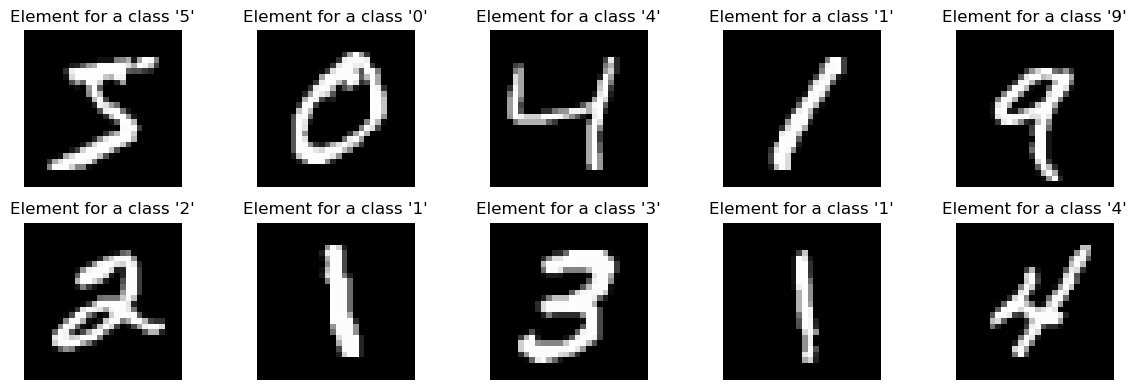

In [6]:
# Selecting random samples for the visual showcase
row_elements = 5

fig, axes = plt.subplots(2, row_elements, figsize=(12, 4), tight_layout=True)

# Display the samples in the image grid
for i, (image, label) in enumerate(
  itertools.islice(train_dataset, 2 * row_elements)
):
    row = i // row_elements
    col = i % row_elements

    axes[row, col].imshow(image.squeeze(), cmap="gray")
    axes[row, col].set_title(f"Element for a class '{label}'")
    axes[row, col].axis("off")

# Show the plot
plt.show()

A blueprint for a convolutional autoencoder neural network

In [7]:
class ConvAutoencoder(nn.Module):    
    def __init__(self, latent_dim=16):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ELU(),

            nn.Flatten(),

            nn.Linear(64 * 7 * 7, 1000),
            nn.ELU(),

            nn.Linear(1000, latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1000),
            nn.ELU(),

            nn.Linear(1000, 64 * 7 * 7),
            nn.ELU(),

            nn.Unflatten(1, (64, 7, 7)),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ELU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

Output dimensions of the decoder network should match the input tensor, to ensure the compatibility of input and output dimensions we will display these tensors on the grid. For untrained network, decoder output is a random noise.

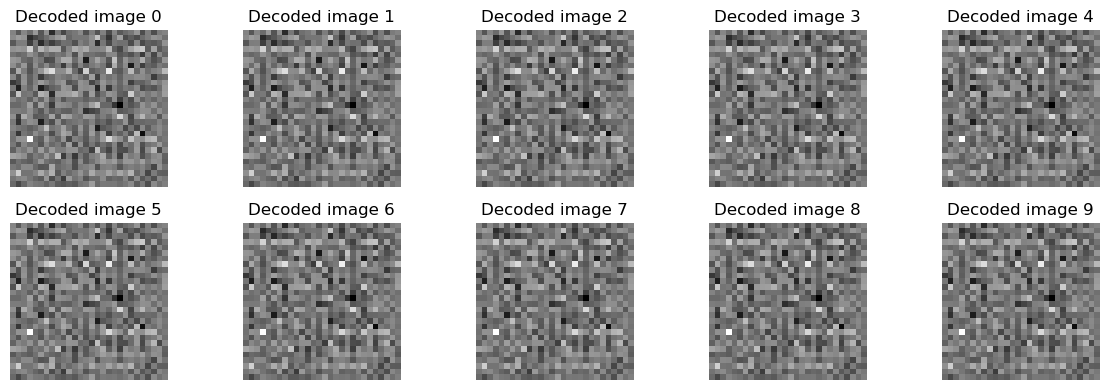

In [8]:
LATENT_DIM = 2

autoenc_model = ConvAutoencoder(latent_dim=LATENT_DIM).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam([
    {'params': autoenc_model.encoder.parameters()},
    {'params': autoenc_model.decoder.parameters()}
], lr=1e-3, weight_decay=1e-05)


images, labels = next(iter(test_dataloader))
fig, axes = plt.subplots(2, row_elements, figsize=(12, 4), tight_layout=True)


for i, image in enumerate(
  itertools.islice(autoenc_model(images.to(device)), 2 * row_elements)
):
    row = i // row_elements
    col = i % row_elements

    axes[row, col].imshow(image.cpu().detach().numpy().squeeze(), cmap="gray")
    axes[row, col].set_title(f"Decoded image {i}")
    axes[row, col].axis("off")

plt.show()

Training an instantiated Convolutional Autoencoder

In [9]:
train_loss, val_loss = [], []


for epoch in range(EPOCHS):
    epoch_train_loss = []
    epoch_val_loss = []

    # Training loss and accuracy
    autoenc_model.train()

    for images, _ in (progress_bar := tqdm(train_dataloader)):
        images = images.to(device)

        # Forward pass
        optimizer.zero_grad()

        outputs = autoenc_model(images)
        loss = criterion(outputs, images)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_train_loss.append(loss.item())
        progress_bar.set_description(f"Train loss: {loss.item():.4f}")

    train_loss.append(np.mean(np.array(epoch_train_loss)))

    # Validation loss and accuracy
    autoenc_model.eval()

    with torch.no_grad():
        for images, _ in test_dataloader:
            images = images.to(device)

            outputs = autoenc_model(images)
            loss = criterion(outputs, images)

            epoch_val_loss.append(loss.item())

    val_loss.append(np.mean(np.array(epoch_val_loss)))

    print(f"Validation loss: {loss.item():.4f}")

Train loss: 0.2235: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 14.79it/s]


Validation loss: 0.2250


Train loss: 0.2176: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 16.07it/s]


Validation loss: 0.2092


Train loss: 0.2102: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.55it/s]


Validation loss: 0.2094


Train loss: 0.2023: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.94it/s]


Validation loss: 0.2032


Train loss: 0.1966: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.95it/s]


Validation loss: 0.2002


Train loss: 0.1901: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.51it/s]


Validation loss: 0.1990


Train loss: 0.1863: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 14.84it/s]


Validation loss: 0.1922


Train loss: 0.1899: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 14.71it/s]


Validation loss: 0.1883


Train loss: 0.1891: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.70it/s]


Validation loss: 0.1854


Train loss: 0.1882: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.66it/s]


Validation loss: 0.1861


Train loss: 0.1859: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.02it/s]


Validation loss: 0.1860


Train loss: 0.1786: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.35it/s]


Validation loss: 0.1797


Train loss: 0.1810: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.85it/s]


Validation loss: 0.1839


Train loss: 0.1857: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.40it/s]


Validation loss: 0.1832


Train loss: 0.1781: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.30it/s]


Validation loss: 0.1771


Train loss: 0.1795: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.44it/s]


Validation loss: 0.1808


Train loss: 0.1799: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.30it/s]


Validation loss: 0.1787


Train loss: 0.1820: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.16it/s]


Validation loss: 0.1769


Train loss: 0.1723: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.16it/s]


Validation loss: 0.1778


Train loss: 0.1761: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 14.90it/s]


Validation loss: 0.1787


Train loss: 0.1771: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.11it/s]


Validation loss: 0.1786


Train loss: 0.1762: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.88it/s]


Validation loss: 0.1775


Train loss: 0.1776: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.02it/s]


Validation loss: 0.1774


Train loss: 0.1751: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.71it/s]


Validation loss: 0.1753


Train loss: 0.1788: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.63it/s]


Validation loss: 0.1762


Train loss: 0.1772: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.83it/s]


Validation loss: 0.1773


Train loss: 0.1776: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.44it/s]


Validation loss: 0.1726


Train loss: 0.1740: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.86it/s]


Validation loss: 0.1765


Train loss: 0.1728: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.85it/s]


Validation loss: 0.1740


Train loss: 0.1742: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.82it/s]


Validation loss: 0.1747


Train loss: 0.1770: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.59it/s]


Validation loss: 0.1808


Train loss: 0.1728: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.64it/s]


Validation loss: 0.1737


Train loss: 0.1741: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.43it/s]


Validation loss: 0.1730


Train loss: 0.1741: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.27it/s]


Validation loss: 0.1760


Train loss: 0.1733: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 14.60it/s]


Validation loss: 0.1805


Train loss: 0.1734: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.91it/s]


Validation loss: 0.1737


Train loss: 0.1682: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.49it/s]


Validation loss: 0.1740


Train loss: 0.1739: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.77it/s]


Validation loss: 0.1754


Train loss: 0.1709: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.64it/s]


Validation loss: 0.1758


Train loss: 0.1719: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.81it/s]


Validation loss: 0.1718


Train loss: 0.1732: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.63it/s]


Validation loss: 0.1748


Train loss: 0.1717: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.94it/s]


Validation loss: 0.1768


Train loss: 0.1741: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.80it/s]


Validation loss: 0.1749


Train loss: 0.1705: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.89it/s]


Validation loss: 0.1703


Train loss: 0.1703: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.86it/s]


Validation loss: 0.1718


Train loss: 0.1704: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.85it/s]


Validation loss: 0.1700


Train loss: 0.1720: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.94it/s]


Validation loss: 0.1743


Train loss: 0.1797: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.91it/s]


Validation loss: 0.1726


Train loss: 0.1713: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.86it/s]


Validation loss: 0.1725


Train loss: 0.1743: 100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.44it/s]


Validation loss: 0.1688


We compare train and validation losses to detect the overfitting of the model

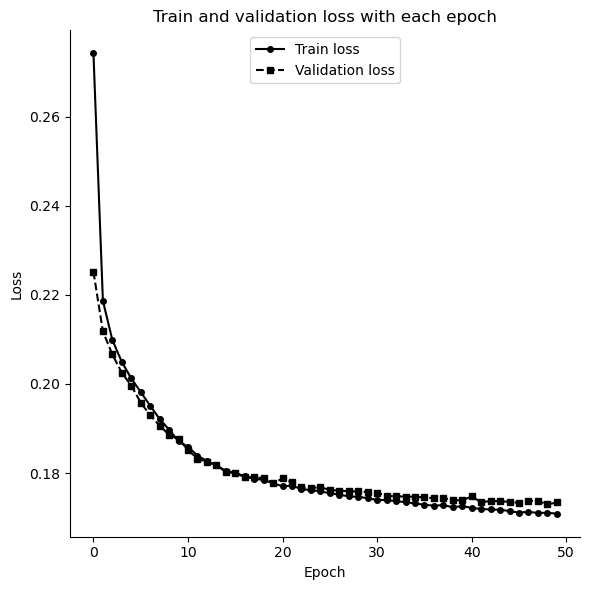

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)

ax.plot(range(len(train_loss)), train_loss, linestyle='-',
           marker='o', color='k', markersize=4, label="Train loss")
ax.plot(range(len(val_loss)), val_loss, linestyle='--',
           marker='s', color='k', markersize=4, label="Validation loss")
ax.legend(loc="upper center")
ax.set_title("Train and validation loss with each epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.patch.set_facecolor('white')

plt.show()

The decoder network outputs resemble an input data, which means encoder-decoder pair formed a bijective mapping from a discrete handwritten digit set, into a metric latent space

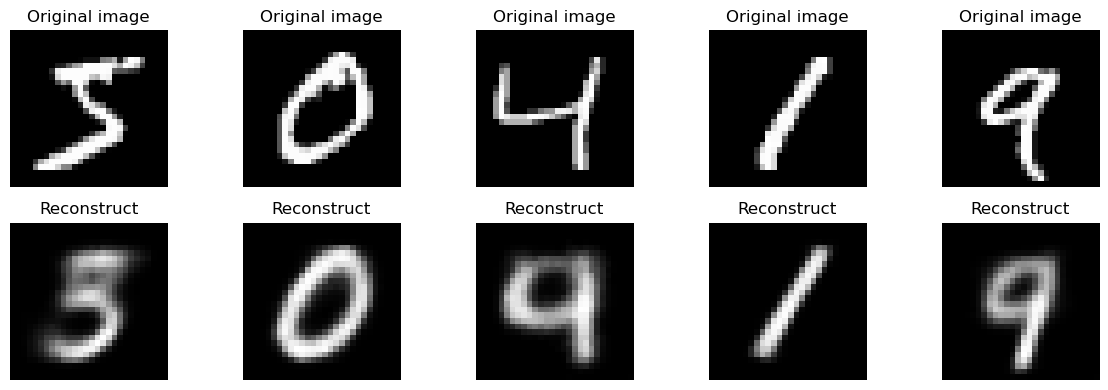

In [11]:
autoenc_model.eval()

row_elements = 5
fig, axes = plt.subplots(2, row_elements, figsize=(12, 4), tight_layout=True)

with torch.no_grad():
    for i, (image, label) in enumerate(
        itertools.islice(train_dataset, row_elements)
    ):
        axes[0, i].imshow(image.squeeze(), cmap="gray")
        axes[0, i].set_title(f"Original image")
        axes[0, i].axis("off")

        inp_image = image.reshape((1, 1, 28, 28)).to(device)

        reconst_image = autoenc_model(inp_image).reshape((1, 28, 28)).cpu()

        axes[1, i].imshow(reconst_image.squeeze(), cmap="gray")
        axes[1, i].set_title(f"Reconstruct")
        axes[1, i].axis("off")

plt.show()

We convert all handwritten digits from the dataset to visualize their embeddings in the metric space

In [12]:
def group_embeddings_by_label(model: nn.Module, dataloader: DataLoader):
    all_embeddings = np.empty((0, LATENT_DIM))
    grouped_embeddings = {i: np.empty((0, LATENT_DIM)) for i in range(10)}

    for img, lbs in dataloader:
        model_device = next(model.parameters()).device
        batch_embeddings = model(img.to(model_device))
        batch_embeddings = batch_embeddings.cpu().detach().numpy()

        lbs = lbs.detach().numpy()

        for emb, lb in zip(batch_embeddings, lbs):
            grouped_embeddings[lb] = np.vstack((grouped_embeddings[lb], np.array(emb)))

    for cl, embeds in grouped_embeddings.items():
        all_embeddings = np.vstack((all_embeddings, np.array(embeds)))

    return grouped_embeddings, all_embeddings


embedding_model = autoenc_model.encoder

with torch.no_grad():
    train_group_embeds, train_all_embeds = group_embeddings_by_label(embedding_model, train_dataloader)
    test_group_embeds, test_all_embeds = group_embeddings_by_label(embedding_model, test_dataloader)

We compare the low-level representations distribution on the 2D scatter plot

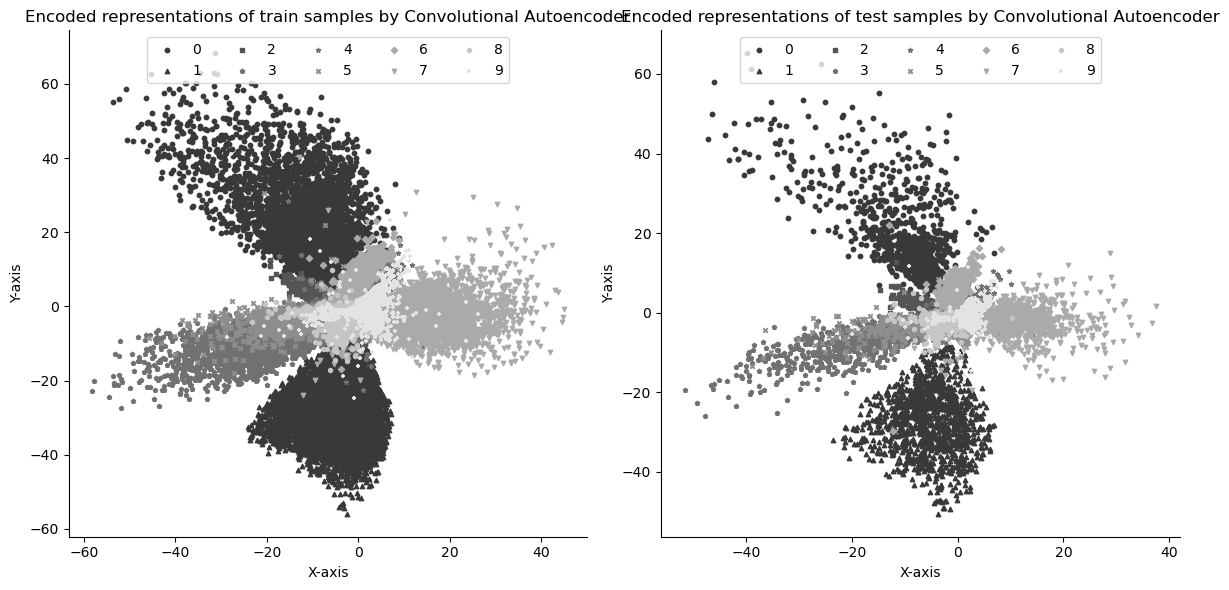

In [13]:
markers = ['o', '^', 's', 'p', '*', 'x', 'D', 'v', 'h', '+']
markers_color = mpl.colormaps['gray'].resampled(len(markers))
markers_color_range = np.linspace(0.2, 0.8, len(markers))
marksize = 10

fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

for idx, (cls, embeds) in enumerate(train_group_embeds.items()):
    cls_color = markers_color(markers_color_range[idx])

    ax[0].scatter(embeds[:, 0], embeds[:, 1], color=cls_color, label=cls,
                  alpha=1.0, s=marksize, marker=markers[idx % len(markers)])

ax[0].legend(loc="upper center", ncol=5)
ax[0].set_title('Encoded representations of train samples by Convolutional Autoencoder')

ax[0].set_xlabel('X-axis')
ax[0].set_ylabel('Y-axis')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

for idx, (cls, embeds) in enumerate(test_group_embeds.items()):
    cls_color = markers_color(markers_color_range[idx])

    ax[1].scatter(embeds[:, 0], embeds[:, 1], color=cls_color, label=cls, alpha=1.0,
                  s=marksize, marker=markers[idx % len(markers)])

ax[1].legend(loc="upper center", ncol=5)
ax[1].set_title('Encoded representations of test samples by Convolutional Autoencoder')

ax[1].set_xlabel('X-axis')
ax[1].set_ylabel('Y-axis')

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

fig.patch.set_facecolor('white')

plt.show()

An autoencoder model is usually applied in the convex of unsupervised learning to create low level representations of unlabeled data, then an algorithm of unsupervised classification performs a grouping of these representations in some metric space. We will use stochastic quantization algorithm for the non-convex optimization problem of representations clustering

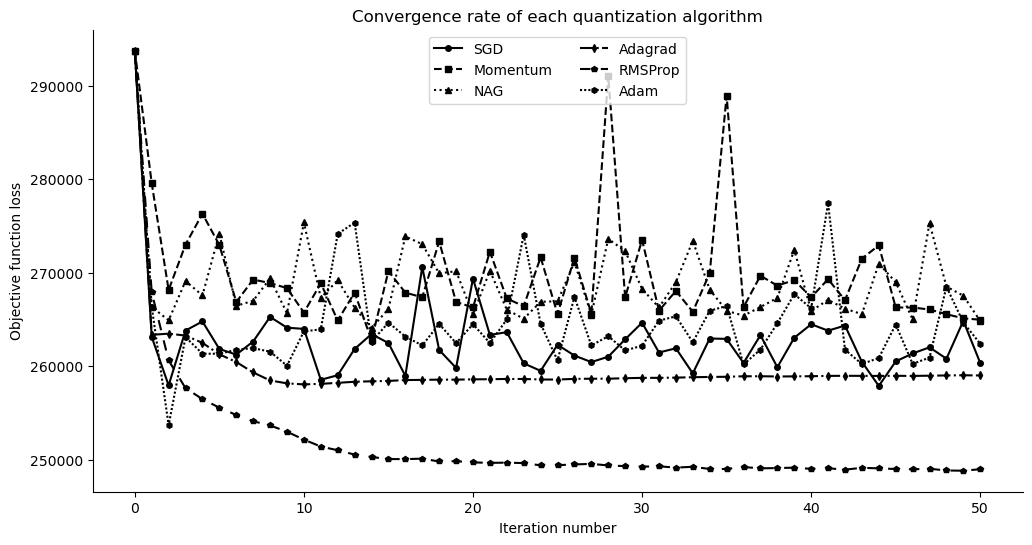

In [18]:
SQ_ITERS = 50

sq_algorithms = {
    "SGD": sq.StochasticQuantization(sq_optim.SGDOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                     random_state=np.random.RandomState(RANDOM_SEED)),
    "Momentum": sq.StochasticQuantization(sq_optim.MomentumOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                          learning_rate=0.0001, random_state=np.random.RandomState(RANDOM_SEED)),
    "NAG": sq.StochasticQuantization(sq_optim.NAGOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                     learning_rate=0.0001, random_state=np.random.RandomState(RANDOM_SEED)),
    "Adagrad": sq.StochasticQuantization(sq_optim.AdagradOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                         learning_rate=0.5, random_state=np.random.RandomState(RANDOM_SEED)),
    "RMSProp": sq.StochasticQuantization(sq_optim.RMSPropOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                         random_state=np.random.RandomState(RANDOM_SEED)),
    "Adam": sq.StochasticQuantization(sq_optim.AdamOptimizer(), n_clusters=10, max_iter=SQ_ITERS,
                                      learning_rate=0.1, random_state=np.random.RandomState(RANDOM_SEED))
}

markers = [('o', '-'), ('s', '--'), ('^', ':'), ('d', '-.'), ('p', (0, (5, 5))), ('h', (0, (1, 1)))]
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for idx, (name, alg) in enumerate(sq_algorithms.items()):
    marker, linestyle = markers[idx % len(markers)]

    alg = alg.fit(train_all_embeds)

    ax.plot(range(len(alg.loss_history_)), alg.loss_history_,
            linestyle=linestyle, marker=marker, color='k',
            markersize=4, label=name)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title("Convergence rate of each quantization algorithm")
plt.xlabel('Iteration number')
plt.ylabel('Objective function loss')
plt.legend(loc="upper center", ncol=2)
plt.show()

We use confusion matrix to compare the accuracy of classification model for each class

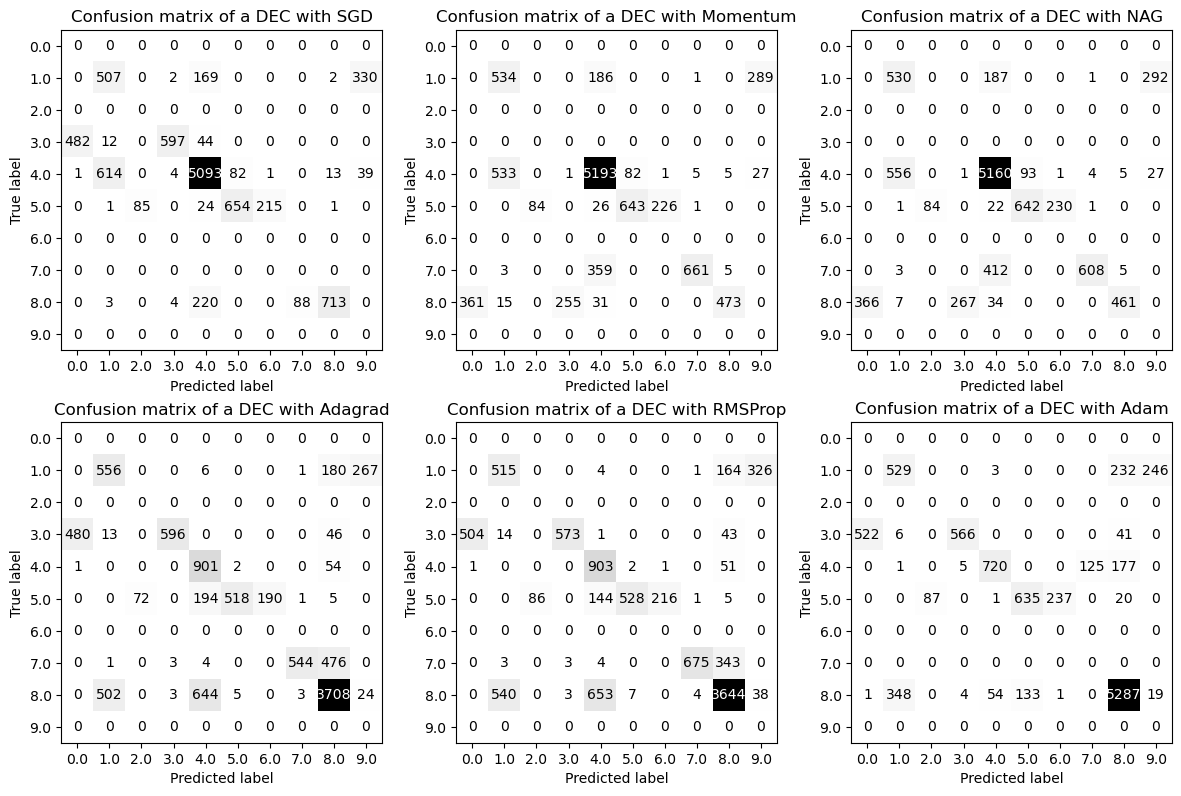

In [19]:
n_col, n_row = (2, 3)
fig, ax = plt.subplots(n_col, n_row, figsize=(12, 8), tight_layout=True)
f1_scores = {}

for idx, (name, alg) in enumerate(sq_algorithms.items()):
    y_true, y_pred = np.array([]), np.array([])

    for _, embs in test_group_embeds.items():
        cls = alg.predict(embs)
        cls_predicted = np.bincount(cls).argmax()

        y_true = np.append(y_true, np.full((1, len(embs)), cls_predicted))
        y_pred = np.append(y_pred, cls)

    ax_idx = ax[idx // n_row, idx % n_row]

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, cmap="Greys", colorbar=False, ax=ax_idx
    )

    ax_idx.set_title(f"Confusion matrix of a DEC with {name}")
    f1_scores[name] = f1_score(y_true, y_pred, average="weighted")

plt.show()

To account for label imbalance in the test set, we choose a weighted F1 score as an accuracy metric.

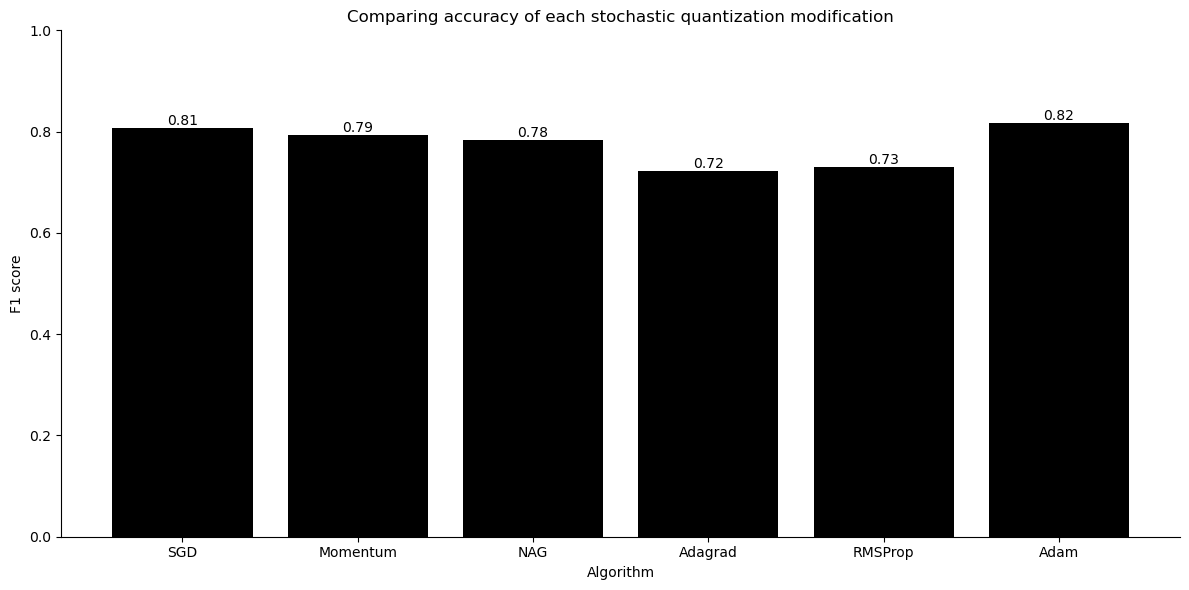

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)

bars = ax.bar(f1_scores.keys(), f1_scores.values(), color='k')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0,
            height, f'{round(height, 2)}', ha='center', va='bottom')

ax.set_xlabel("Algorithm")
ax.set_ylabel("F1 score")
ax.set_title("Comparing accuracy of each stochastic quantization modification")
ax.set_ylim(top=1.0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Save encoder model for the later use

In [17]:
MODEL_DIR = os.path.join(RESULTS_DIR, "model")

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

embedding_model.eval()

torch.save(embedding_model.state_dict(), os.path.join(MODEL_DIR, "embedding_model.bin"))